<a href="https://colab.research.google.com/github/ivnlee/tec-mna-nlp/blob/main/semana-6-7/Equipo13_semana6y7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Modelado de Temas : LSI / LDA

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd 
import numpy as np 
import re
import nltk
from nltk.corpus import stopwords 

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### 1. Cargar el archivo
Genera un DataFrame de Pandas llamado “df” y que contiene una única columna llamada “noticia” con 5658 renglones formados por los cuerpos de las noticias.

In [ ]:
dfn = pd.read_json('/content/drive/MyDrive/NLP/semana-6-7/noticiasTopicModeling.txt', lines=False, encoding='utf-8')

df = dfn[['texto']].copy()
df.rename(columns={'texto':'noticia'}, inplace=True)

In [ ]:
print(df.shape)
df.head()

(5658, 1)


,noticia
0,"""España ha dejado de ser católica"", decía Manu..."
1,El clima de crispación social en Ceuta ha lleg...
2,El Gobierno ha alegado la suspensión de plazos...
3,"Puedes mandar tu pregunta, sugerencia o queja ..."
4,Panamá debe entregar esta semana a la Corte In...


### 2. Proceso de Limpieza 

In [ ]:
# stopwords en español
stops = stopwords.words('spanish')

def clean_tok(doc):
  # Elimina los signos de puntuación, caracteres especiales y números
  tokens = re.sub(r'[^A-Za-záéíóúüñ\s]', ' ', doc).strip()

  # Elimina espacios en blanco adicionales y convierte a minúsculas
  tokens = ' '.join(re.findall(r'\b\w+\b', tokens.lower()))
  
  # Tokeniza por palabras, elimina stopwords y palabras de longitud menor a 2
  tokens = [w for w in tokens.split() if w not in stops and len(w) > 2]

  return tokens

In [ ]:
clean_doc = [clean_tok(x) for x in df['noticia']]

In [ ]:
print(clean_doc[0][0:20])

['españa', 'dejado', 'ser', 'católica', 'decía', 'manuel', 'azaña', 'comienzo', 'segunda', 'república', 'aquel', 'congreso', 'diputados', 'aprobó', 'leyes', 'laicistas', 'metáfora', 'dejó', 'ser', 'católica']


### 3. ¿Por qué en este caso no requerimos hacer una partición en entrenamiento, validación y prueba?

En esta actividad no se va a entrenar un modelo de clasificación, sino que se va a realizar un análisis para extraer el tema o temas de un texto. Dicho análisis se realiza con modelos no supervisados, por lo que no se requiere de una partición en entrenamiento, validación y prueba.

## Parte 1: Indexación semántica latente (LSI)

### 4. Matriz Tf-Idf
Encontrar la matriz Tf-idf de la columna de noticias. Despliega los primeros 5 renglones con algunas de sus columnas con sus nombres, donde las columnas son los tokens.

In [ ]:
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer 

In [ ]:
# Construimos vocabulario de palabras con base al conteo de tokens
midiccionario = Counter()

for k in range(len(clean_doc)):
  midiccionario.update(clean_doc[k])

In [ ]:
print('Longitud del diccionario:', len(midiccionario))  
print(midiccionario.most_common(10)) 

Longitud del diccionario: 100089
[('gobierno', 10326), ('años', 7545), ('dos', 7400), ('personas', 7068), ('coronavirus', 6787), ('ser', 6652), ('madrid', 6173), ('según', 6050), ('españa', 6014), ('parte', 5957)]


In [ ]:
# Convertimos cada renglón en un solo string

clean_doc = [' '.join(x) for x in clean_doc] 

In [ ]:
# Obtenemos nuestro vocabulario de tokens
vocab = list(midiccionario.keys())

# Creamos instancia de TfidfVectorizer con nuestro vocabulario
tfidfvectorizer = TfidfVectorizer(vocabulary=vocab, norm=None)

matriz_tfidf = tfidfvectorizer.fit_transform(clean_doc)

tfidf_tokens = tfidfvectorizer.get_feature_names_out()
df_tfidf = pd.DataFrame(data = matriz_tfidf.toarray(), columns = tfidf_tokens)

# Imprimimos los primeros 5 renglones
print(df_tfidf.iloc[0:5, 0:])

      españa    dejado       ser   católica     decía    manuel     azaña  \
0  13.661420  9.529243  8.220060  11.060257  3.835868  6.611896  7.338417   
1   1.951631  0.000000  1.644012   0.000000  0.000000  0.000000  0.000000   
2   1.951631  0.000000  1.644012   0.000000  0.000000  0.000000  0.000000   
3   0.000000  0.000000  4.932036   0.000000  0.000000  3.305948  0.000000   
4   0.000000  0.000000  1.644012   0.000000  0.000000  0.000000  0.000000   

   comienzo  segunda  república  ...  cicala  venerd  anarchici  mainl  \
0  4.327796  2.83528   4.308284  ...     0.0     0.0        0.0    0.0   
1  0.000000  0.00000   0.000000  ...     0.0     0.0        0.0    0.0   
2  0.000000  0.00000   0.000000  ...     0.0     0.0        0.0    0.0   
3  0.000000  0.00000   0.000000  ...     0.0     0.0        0.0    0.0   
4  0.000000  0.00000   0.000000  ...     0.0     0.0        0.0    0.0   

   hartmann  polvorientos  aqueos  iliada  rebajarla  adaya  
0       0.0           0.0     

**¿Cuál es el significado de cada renglón?** 

Cada renglón en nuestra matriz tf-idf representa el cuerpo de una noticia, o bien, cada renglón es un documento.

**¿Y el significado de cada columna?**

Cada columna representa un token, es decir, una palabra que aparece en el cuerpo de las noticias. El número de columnas es igual al número de tokens que aparecen en todos los documentos.

### 5. Descomposición en valores singulares (SVD)
Aplica el método de descomposición de valores singulares truncado a la matriz Tf-idf anterior con 10 componentes y obtener el gráfico de la importancia relativa de estas.

In [ ]:
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
num_comp = 10

# Descomposición SVD
SVD = TruncatedSVD(n_components=num_comp, n_iter=100, random_state=42)
sv_mtx = SVD.fit_transform(matriz_tfidf) 

# matriz 'sigma' diagonal con los valores singulares
Sigma = SVD.singular_values_
sv_mtx.shape

(5658, 10)

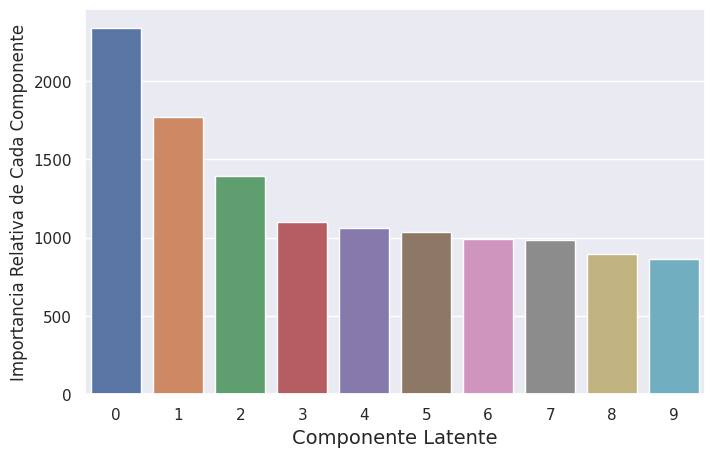

In [ ]:
# Gráfica de importancia relativa de cada componente
sns.set(rc={'figure.figsize':(8, 5)})
chart = sns.barplot(x=list(range(len(Sigma))), y=Sigma)
chart.set_xlabel('Componente Latente', fontdict={'size': 14})
chart.set_ylabel('Importancia Relativa de Cada Componente', fontdict={'size': 12})
plt.show()

### 6. Obtener la matriz tokens-temas (term-topic) a partir de la matriz $𝑉^T$ de la descomposición SVD.
Despliega sus primeros 5 renglones donde se incluya el nombre de las columnas.

In [ ]:
# Obtener la matriz V.T
V_T = SVD.components_.T

term_topic = V_T
term_topic.shape

(100089, 10)

In [ ]:
# Obtener los nombres de los términos
term_names = list(tfidfvectorizer.get_feature_names_out())

# Construir dataframe de la matriz term-topic
term_topic_mtx = pd.DataFrame(data=term_topic, index=term_names, 
                              columns=['Concepto_Latente_'+str(i) for i in range(0, num_comp)])

print(term_topic_mtx.shape)

(100089, 10)


In [ ]:
# Imprimir los primeros 5 renglones
term_topic_mtx.head(5)

,Concepto_Latente_0,Concepto_Latente_1,Concepto_Latente_2,Concepto_Latente_3,Concepto_Latente_4,Concepto_Latente_5,Concepto_Latente_6,Concepto_Latente_7,Concepto_Latente_8,Concepto_Latente_9
españa,0.092164,-0.007174,-0.002378,-0.054059,0.028084,0.014302,-0.002177,-0.001419,-0.026396,-0.016163
dejado,0.016543,-0.002355,-0.004313,-0.006347,0.001586,-0.000192,-0.002542,0.006867,-0.000281,-0.004753
ser,0.086672,0.004549,0.007282,0.018572,-0.013114,-0.051896,0.021869,-0.022062,-0.041927,-0.007556
católica,0.003085,-0.000337,-0.003085,0.000060,-0.000988,-0.004175,0.001293,-0.004966,-0.002476,-0.000313
decía,0.013632,-0.000755,-0.013170,0.001722,0.001238,-0.005899,0.000345,-0.003411,-0.014538,0.001548


### 7-8. Para cada uno de los 10 conceptos latentes obtenidos con la descomposición SVD, obtener el gráfico de barras que muestre los 10 términos/tokens más importantes de cada uno de ellos.

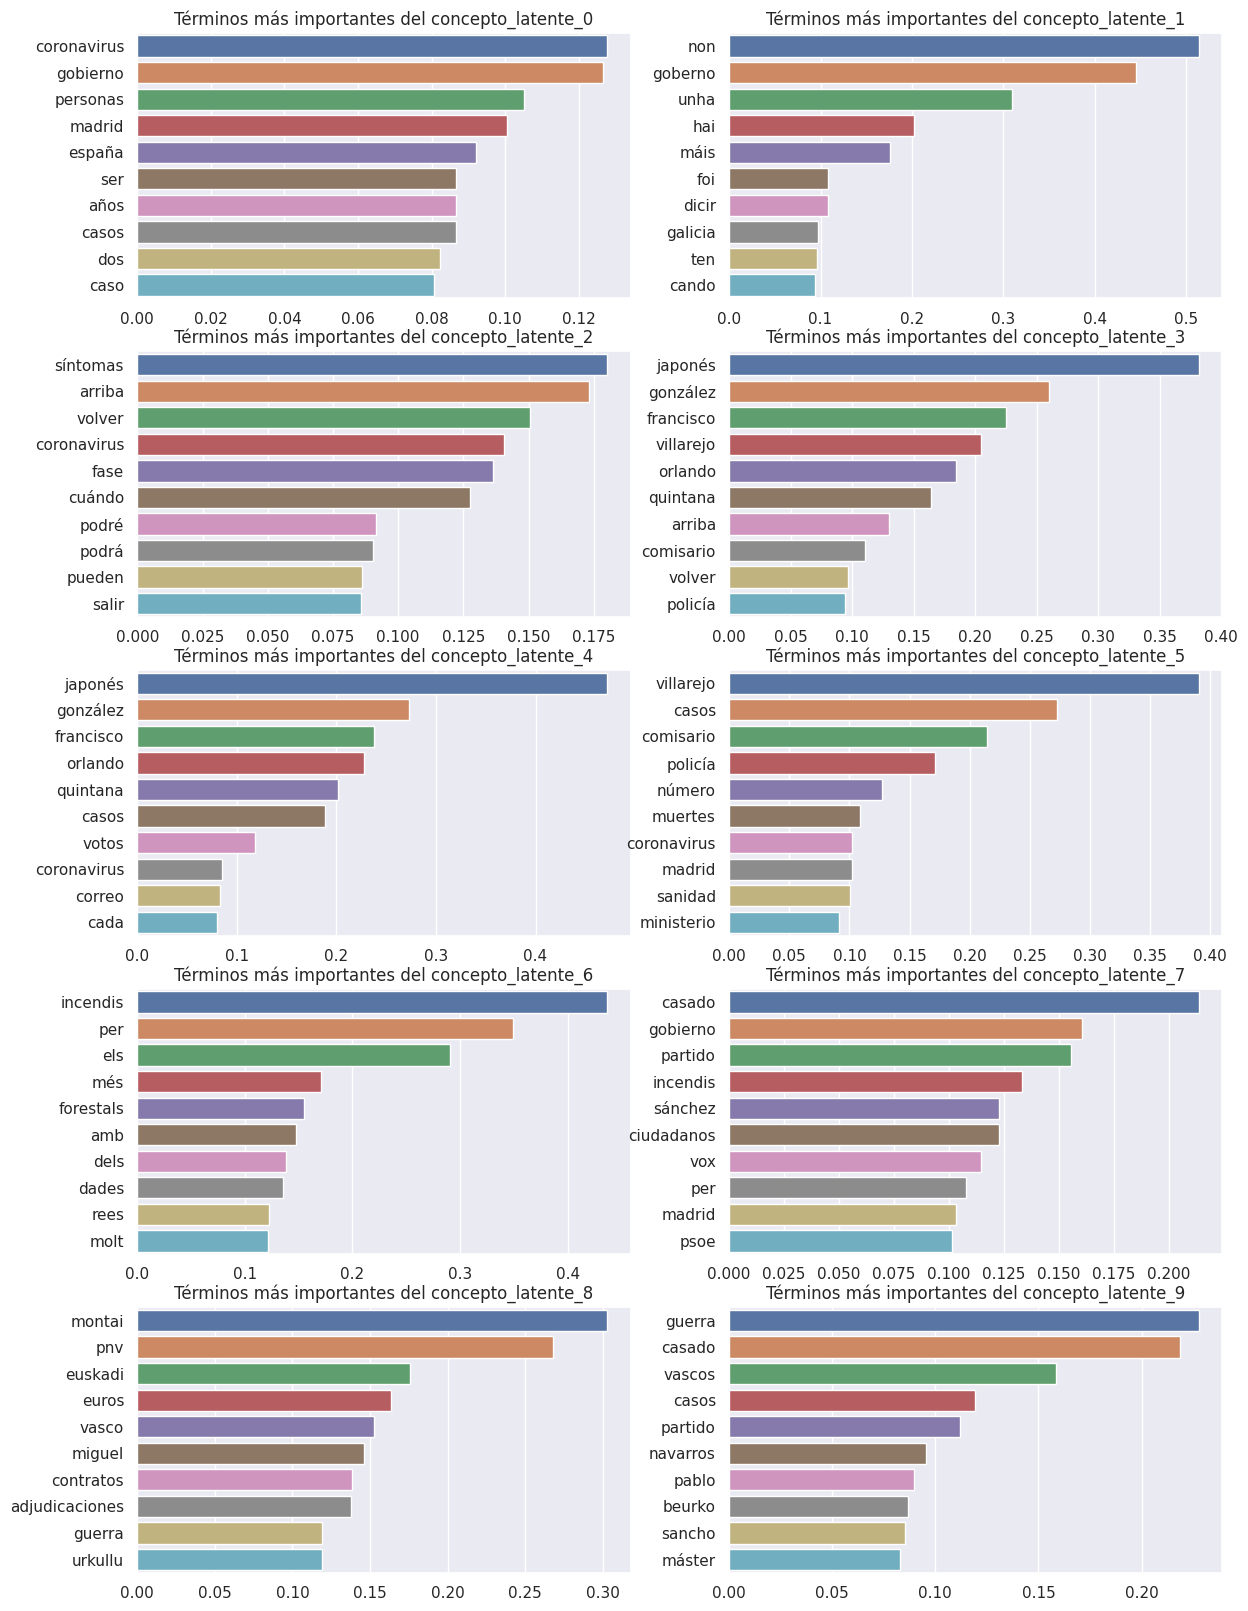

In [ ]:
top = 10

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(14, 20))

for i in range(0, num_comp):
    data = term_topic_mtx['Concepto_Latente_'+str(i)].sort_values(ascending=False)
    top_term_mtx = data[:top]
    plt.subplot(5, 2, i + 1)
    plt.title('Términos más importantes del concepto_latente_'+str(i))
    ax = sns.barplot(x=top_term_mtx.values, y=top_term_mtx.index)

plt.show()

### 9. ¿Cuántos tópicos o conceptos latentes identificas con claridad? ¿Cómo los describirías, es decir, de qué temáticas estarían hablando?

En general podríamos identificar con mas claridad 5 temas:

* El tópico o tema que se distingue con mas claridad es el de la **Pandemia**, por ejemplo, en los conceptos latentes 0 y 2 encontramos las palabras "coronavirus", "síntomas", "casos" etc..

* Otro tópico que se distingue es el de **Política** o **Gobierno**, en los conceptos latentes 1 y 7 observamos palabras como "gobierno", "partido", "ciudadanos", y "vox", "psoe" que son partidos políticos de España.

* Observamos en el componente latente 6 palabras en Catalán, en donde el tópico parece estar hablando de **Medio ambiente** con las palabras "incendis" y "forestals" (incendios y forestales en español). Aqui observamos que durante la limpieza de los datos solo eliminamos stopwords en español, por lo que para un mejor resultado podríamos considerar eliminar stopwords en catalán.

* Los componentes latentes 8 y 9 parecen estar hablando de la región del **País Vasco** en España, y mas en específico sobre conflíctos políticos ya que encontramos palabras como "guerra", "euskadi", "vasco", 
"navarros".

* Otro tema que podemos considerar en el componente 5, es el de **Crimen** o **Policiaco** aunque es un poco ambiguo ya que tambien aparece la palabra "coronavirus".

* En el caso del componente latente 4 no queda muy claro el tema principalmente debido a que los tokens principales son nombres y apellidos de personas. Vemos aquí tembién una mezcla, por ejemplo con palabras como "coronavirus" y "votos".

### 10. Modelo LSI con Gensim
Obtener los modelos de 2 a 10 temas/tópicos y para cada uno de ellos obtener su valor (score) de coherencia.

In [ ]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel 

In [ ]:
# Generamos nuevamente documentos tokenizdos
docs = [clean_tok(x) for x in df['noticia']]

In [ ]:
# Creamos diccionario
mi_dicc = corpora.Dictionary(docs)

# Bolsa de palabras
bow = [mi_dicc.doc2bow(doc) for doc in docs]

In [ ]:
# Generamos modelo LSI iterando de 2 a 10 temas o clusters
for i in range(2, 11):
  lsi = LsiModel(bow, num_topics=i,
                 id2word=mi_dicc,
                 chunksize=100,
                 random_seed=42
                 )
  
  # Calculamos la métrica de coherencia para cada modelo generado
  cm = CoherenceModel(model=lsi, texts=docs,
                      dictionary=mi_dicc,
                      window_size=3,
                      coherence='c_v',
                      topn=10
                      )
  
  cs = cm.get_coherence()

  print('Métrica de Coherencia con {} clusters: {}'.format(i, cs))

Métrica de Coherencia con 2 clusters: 0.2331331198935564
Métrica de Coherencia con 3 clusters: 0.21632968253840723
Métrica de Coherencia con 4 clusters: 0.313338210122302
Métrica de Coherencia con 5 clusters: 0.3140171591952334
Métrica de Coherencia con 6 clusters: 0.3265841733968893
Métrica de Coherencia con 7 clusters: 0.2912512845319952
Métrica de Coherencia con 8 clusters: 0.30710847689882137
Métrica de Coherencia con 9 clusters: 0.3107212417202516
Métrica de Coherencia con 10 clusters: 0.33807237442803834


In [ ]:
# seleccionamos el mejor modelo
lsi = LsiModel(bow, num_topics=10,
                 id2word=mi_dicc,
                 chunksize=100,
                 random_seed=42
                 )

for topic_n, words in lsi.print_topics(num_words=10):
  print('Tokens/Palabras en Tema {}: {}.'.format(topic_n, words))

Tokens/Palabras en Tema 0: 0.216*"gobierno" + 0.161*"coronavirus" + 0.156*"personas" + 0.142*"dos" + 0.141*"años" + 0.141*"ser" + 0.132*"españa" + 0.128*"madrid" + 0.116*"caso" + 0.110*"cada".
Tokens/Palabras en Tema 1: -0.291*"casos" + -0.275*"coronavirus" + -0.182*"personas" + 0.175*"partido" + 0.165*"gobierno" + -0.148*"síntomas" + -0.131*"cada" + -0.131*"covid" + 0.120*"política" + -0.116*"sanidad".
Tokens/Palabras en Tema 2: 0.409*"casos" + 0.191*"madrid" + 0.183*"número" + 0.173*"cada" + -0.169*"volver" + 0.154*"datos" + -0.137*"arriba" + -0.133*"ser" + -0.122*"casa" + 0.117*"gobierno".
Tokens/Palabras en Tema 3: 0.387*"gobierno" + 0.279*"madrid" + -0.190*"casos" + -0.159*"años" + -0.130*"guerra" + -0.128*"mujeres" + 0.125*"partido" + 0.121*"ciudadanos" + 0.118*"sánchez" + 0.118*"ayuso".
Tokens/Palabras en Tema 4: 0.415*"non" + 0.268*"goberno" + -0.245*"villarejo" + 0.203*"unha" + 0.187*"galicia" + -0.179*"policía" + -0.135*"comisario" + 0.130*"hai" + 0.124*"país" + -0.123*"caso"

In [ ]:
# Probamos con 5 topicos
lsi = LsiModel(bow, num_topics=5,
                 id2word=mi_dicc,
                 chunksize=100,
                 random_seed=42
                 )

for topic_n, words in lsi.print_topics(num_words=10):
  print('Tokens/Palabras en Tema {}: {}.'.format(topic_n, words))

Tokens/Palabras en Tema 0: 0.217*"gobierno" + 0.160*"coronavirus" + 0.156*"personas" + 0.142*"dos" + 0.141*"ser" + 0.141*"años" + 0.132*"españa" + 0.129*"madrid" + 0.116*"caso" + 0.109*"cada".
Tokens/Palabras en Tema 1: -0.250*"coronavirus" + -0.246*"casos" + -0.187*"personas" + -0.171*"síntomas" + 0.161*"partido" + 0.157*"gobierno" + -0.133*"volver" + -0.126*"covid" + -0.122*"fase" + 0.117*"política".
Tokens/Palabras en Tema 2: 0.414*"casos" + 0.182*"madrid" + 0.181*"número" + 0.172*"cada" + 0.162*"datos" + -0.152*"casa" + -0.147*"volver" + 0.126*"gobierno" + -0.125*"arriba" + 0.115*"comunidad".
Tokens/Palabras en Tema 3: -0.540*"non" + -0.349*"goberno" + -0.264*"unha" + -0.204*"galicia" + -0.169*"hai" + -0.143*"máis" + -0.141*"país" + -0.112*"feijóo" + -0.103*"coalición" + -0.093*"creo".
Tokens/Palabras en Tema 4: 0.452*"japonés" + 0.442*"gonzález" + 0.411*"francisco" + 0.186*"votos" + 0.183*"orlando" + 0.177*"quintana" + 0.141*"partido" + 0.114*"correo" + 0.103*"dinero" + 0.092*"eur

## Parte 2: Asignación de Dirichlet Latente (LDA)

### 11. Utiliza la librería Gensim para implementar ahora la técnica de LDA.
Revisa la documentación correspondiente y aplica de preferencia el modelo paralelizable.

In [ ]:
from gensim.models.ldamulticore import LdaMulticore

In [ ]:
# generamos el diccionario:

id2word = corpora.Dictionary(docs)

for id in range(5):
    print(id2word[id])

abascal
abril
actores
afd
ahora


In [ ]:
# Generamos el corpus con las tuplas (índice, frecuencia):

corpus = [id2word.doc2bow(doc) for doc in docs]

In [ ]:
# 1. Entrenamos modelo LDA paralelizable (multicore)
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10,
                                       chunksize=100,
                                       passes=10,
                                       alpha=0.5,
                                       eta=0.5
                                       )

In [ ]:
# Imprimimos los 10 temaas con sus 10 principales palabras
lda_model.print_topics(num_topics=10, num_words=10)

[(0,
  '0.011*"coronavirus" + 0.007*"personas" + 0.007*"casos" + 0.005*"pandemia" + 0.005*"madrid" + 0.005*"días" + 0.005*"covid" + 0.005*"cada" + 0.005*"datos" + 0.004*"comunidad"'),
 (1,
  '0.006*"trump" + 0.005*"país" + 0.005*"unidos" + 0.004*"migrantes" + 0.004*"efe" + 0.004*"internacional" + 0.003*"israel" + 0.003*"dijo" + 0.003*"eeuu" + 0.003*"norte"'),
 (2,
  '0.005*"años" + 0.005*"ser" + 0.003*"mujeres" + 0.003*"solo" + 0.003*"puede" + 0.003*"vida" + 0.003*"mundo" + 0.003*"hace" + 0.003*"vez" + 0.003*"dos"'),
 (3,
  '0.003*"per" + 0.001*"ncia" + 0.001*"non" + 0.001*"els" + 0.001*"val" + 0.001*"amb" + 0.001*"segur" + 0.001*"goberno" + 0.001*"més" + 0.001*"unha"'),
 (4,
  '0.009*"gobierno" + 0.005*"partido" + 0.005*"política" + 0.004*"dos" + 0.004*"caso" + 0.004*"madrid" + 0.004*"podemos" + 0.003*"presidente" + 0.003*"según" + 0.003*"sánchez"'),
 (5,
  '0.001*"and" + 0.001*"vitamina" + 0.001*"cigarrillos" + 0.001*"cardiovasculares" + 0.001*"suplementos" + 0.001*"lactobacillus" + 

In [ ]:
# 2. Probamos modelo LDA con 8 temas
lda_model_ = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=8,
                                       chunksize=50,
                                       passes=10,
                                       alpha=0.5,
                                       eta=0.5
                                       )

In [ ]:
lda_model_.print_topics(num_topics=8, num_words=10)

[(0,
  '0.005*"años" + 0.005*"ser" + 0.003*"mujeres" + 0.003*"vida" + 0.003*"solo" + 0.003*"puede" + 0.003*"mundo" + 0.003*"historia" + 0.002*"hace" + 0.002*"cómo"'),
 (1,
  '0.011*"coronavirus" + 0.008*"personas" + 0.007*"casos" + 0.005*"pandemia" + 0.005*"días" + 0.005*"cada" + 0.005*"covid" + 0.005*"madrid" + 0.005*"datos" + 0.004*"comunidad"'),
 (2,
  '0.009*"trump" + 0.006*"israel" + 0.005*"unidos" + 0.004*"brasil" + 0.004*"eeuu" + 0.003*"donald" + 0.003*"país" + 0.003*"efe" + 0.003*"kim" + 0.003*"washington"'),
 (3,
  '0.021*"euskadi" + 0.014*"pnv" + 0.012*"vasco" + 0.007*"vitoria" + 0.007*"urkullu" + 0.006*"montai" + 0.006*"miguel" + 0.006*"osakidetza" + 0.005*"vasca" + 0.005*"puedes"'),
 (4,
  '0.011*"rey" + 0.009*"máster" + 0.009*"carlos" + 0.008*"juan" + 0.008*"cifuentes" + 0.007*"universidad" + 0.005*"emérito" + 0.005*"larsen" + 0.004*"urjc" + 0.004*"corinna"'),
 (5,
  '0.008*"guerra" + 0.004*"migrantes" + 0.004*"memoria" + 0.003*"franco" + 0.003*"valle" + 0.003*"norte" + 0.

### 12. ¿Qué cantidad de tópicos consideras que es la más adecuada?
El análisis con el método LDA nos da términos mas claros para cada tema, podemos considerar los siguientes:

| Tema # | Tópico |
| :---   | :------: |
| Tema 0 | Pandemia |
| Tema 1 | Noticias Internacionales |
| Tema 2 | ? |
| Tema 3 | ? |
| Tema 4 | Política |
| Tema 5 | Alimentación/Salud |
| Tema 6 | Medio ambiente |
| Tema 7 | Arte/Cultura |
| Tema 8 | Economía |
| Tema 9 | Noticias Locales |

### Compara tus resultados con el método LSI. ¿Qué encuentras de coincidencias y diferencias?

### ¿Cuál consideras puede ser la mejor cantidad de tópicos a considerar?

### 13. La librería pyLDAvis nos ayuda a visualizar de manera interactiva los temas y tokens de los documentos analizados. Revisa la documentación y utilízala para visualizar tus mejor resultado.

In [ ]:
!pip install pyLDAvis

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models

In [ ]:
# habilitamos el notebook para desplegar la visualización
pyLDAvis.enable_notebook()

# Generamos la visualización de nuestro modelo
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=10, n_jobs=1)
# desplegamos la visualización
pyLDAvis.display(vis)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


### 14. Conclusión final

...